In [8]:
import time
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax import jit
from jax.scipy.stats import norm

# split method
from sklearn.linear_model import LassoCV

import pandas as pd
from run_scripts.load_data import load_traintest_sparsereg
from conformal_bayes import conformal_Bayes_functions as cb
from conformal_bayes import Bayes_MCMC_functions as bmcmc
%reload_ext autoreload
%autoreload 2

In [9]:
#Load Data
dataset = 'diabetes'
#dataset = 'boston'
seed = 100
B = 2000

train_frac = 0.7
x,y,x_test,y_test,y_plot,n,d = load_traintest_sparsereg(train_frac,dataset,seed)


### Check ESS

In [10]:
from theano import tensor as tt
import pymc3 as pm

#Horseshoe
def fit_mcmc_laplace(y,x,B,seed = 100,misspec = False):
    with pm.Model() as model:
        p = np.shape(x)[1]

        #Laplace
        b = pm.Gamma('b',alpha = 1,beta = 1)
        beta = pm.Laplace('beta',mu = 0, b = b,shape = p)
        intercept = pm.Flat('intercept')

        if misspec == True:
            sigma = pm.HalfNormal("sigma", sigma = 0.02) ## misspec
        else:
            sigma = pm.HalfNormal("sigma", sigma = 1) 
        obs = pm.Normal('obs',mu = pm.math.dot(x,beta)+ intercept,sigma = sigma,observed=y)

        trace = pm.sample(B,random_seed = seed)
    return trace

In [11]:
#MCMC + check ESS
#No Misspec
trace = fit_mcmc_laplace(y,x,B,seed = seed,misspec = False)
pm.summary(trace).round(2)

/var/folders/4v/fb1p6s1x2tdc8y9n6r_c4tbh0000gs/T/ipykernel_68973/3697169613.py:20: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(B,random_seed = seed)
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, intercept, beta, b]
INFO:pymc3:NUTS: [sigma, intercept, beta, b]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 17 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 17 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/Users/efong/virtualenv/conformal/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-0.01,0.04,-0.09,0.06,0.0,0.0,8921.0,5716.0,1.0
beta[1],-0.10,0.05,-0.19,-0.02,0.0,0.0,8581.0,5210.0,1.0
beta[2],0.36,0.05,0.27,0.46,0.0,0.0,7749.0,4707.0,1.0
beta[3],0.18,0.05,0.09,0.26,0.0,0.0,8030.0,5235.0,1.0
beta[4],-0.14,0.14,-0.43,0.10,0.0,0.0,3565.0,3244.0,1.0
beta[5],-0.00,0.12,-0.23,0.23,0.0,0.0,3756.0,3343.0,1.0
beta[6],-0.06,0.08,-0.22,0.09,0.0,0.0,4297.0,4389.0,1.0
beta[7],0.04,0.08,-0.11,0.21,0.0,0.0,6541.0,4892.0,1.0
beta[8],0.37,0.08,0.22,0.52,0.0,0.0,4553.0,3405.0,1.0
beta[9],0.04,0.05,-0.04,0.13,0.0,0.0,8734.0,5442.0,1.0


In [12]:
#Misspec
trace_misspec = fit_mcmc_laplace(y,x,B,seed = seed,misspec = True)
pm.summary(trace_misspec).round(2)

/var/folders/4v/fb1p6s1x2tdc8y9n6r_c4tbh0000gs/T/ipykernel_68973/3697169613.py:20: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(B,random_seed = seed)
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, intercept, beta, b]
INFO:pymc3:NUTS: [sigma, intercept, beta, b]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 21 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 21 seconds.
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/Users/efong/virtualenv/conformal/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-0.01,0.03,-0.06,0.04,0.0,0.0,7854.0,4961.0,1.0
beta[1],-0.12,0.03,-0.17,-0.06,0.0,0.0,8508.0,5542.0,1.0
beta[2],0.36,0.03,0.30,0.42,0.0,0.0,7482.0,5938.0,1.0
beta[3],0.18,0.03,0.13,0.24,0.0,0.0,7512.0,5796.0,1.0
beta[4],-0.26,0.15,-0.55,-0.01,0.0,0.0,2598.0,2254.0,1.0
beta[5],0.09,0.12,-0.12,0.34,0.0,0.0,2791.0,2557.0,1.0
beta[6],-0.02,0.07,-0.15,0.12,0.0,0.0,2940.0,2652.0,1.0
beta[7],0.05,0.06,-0.07,0.16,0.0,0.0,5466.0,5167.0,1.0
beta[8],0.42,0.07,0.31,0.55,0.0,0.0,2924.0,2665.0,1.0
beta[9],0.04,0.03,-0.02,0.10,0.0,0.0,8795.0,6357.0,1.0


In [13]:
#Compute conformal interval
beta_post = jnp.array(trace['beta'])
intercept_post = jnp.array(trace['intercept'].reshape(-1,1))
sigma_post = jnp.array(trace['sigma'].reshape(-1,1))

alpha = 0.2
rep = np.shape(beta_post)[0]
n_test = np.shape(x_test)[0]

coverage_cp = np.zeros(n_test)
length_cp = np.zeros(n_test)
region_cp = np.zeros((n_test,np.shape(y_plot)[0]))
ESS = np.zeros((n_test,np.shape(y_plot)[0],1))
Var = np.zeros((n_test,np.shape(y_plot)[0],1))

j = 0
seed = 100 + j
x,y,x_test,y_test,y_plot,n,d = load_traintest_sparsereg(train_frac,dataset,seed)
y_plot = np.linspace(-7,4,100)
dy = y_plot[1] - y_plot[0]

@jit
def normal_loglikelihood(y,x):
    return norm.logpdf(y,loc = jnp.dot(beta_post,x.transpose())+ intercept_post,scale = sigma_post) #compute likelihood samples

logp_samp_n = normal_loglikelihood(y,x)
logwjk = normal_loglikelihood(y_plot.reshape(-1,1,1),x_test)
logwjk_test = normal_loglikelihood(y_test,x_test).reshape(1,-1,n_test)

In [14]:
#Compute conformal interval
beta_post = jnp.array(trace_misspec['beta'])
intercept_post = jnp.array(trace_misspec['intercept'].reshape(-1,1))
sigma_post = jnp.array(trace_misspec['sigma'].reshape(-1,1))

alpha = 0.2
rep = np.shape(beta_post)[0]
n_test = np.shape(x_test)[0]

coverage_cp = np.zeros(n_test)
length_cp = np.zeros(n_test)
region_cp = np.zeros((n_test,np.shape(y_plot)[0]))
ESS_misspec = np.zeros((n_test,np.shape(y_plot)[0],1))
Var_misspec = np.zeros((n_test,np.shape(y_plot)[0],1))

j = 0
seed = 100 + j
x,y,x_test,y_test,y_plot,n,d = load_traintest_sparsereg(train_frac,dataset,seed)
y_plot = np.linspace(-7,4,100)
dy = y_plot[1] - y_plot[0]

@jit
def normal_loglikelihood(y,x):
    return norm.logpdf(y,loc = jnp.dot(beta_post,x.transpose())+ intercept_post,scale = sigma_post) #compute likelihood samples

logp_samp_n_misspec = normal_loglikelihood(y,x)
logwjk_misspec = normal_loglikelihood(y_plot.reshape(-1,1,1),x_test)
logwjk_test_misspec = normal_loglikelihood(y_test,x_test).reshape(1,-1,n_test)

In [135]:
#well spec
i = 1
alpha_range= np.array([0.2,0.5])
n_alph = np.shape(alpha_range)[0]
region_cp = np.zeros((n_alph,np.shape(y_plot)[0]))
ind_band = np.zeros((n_alph,2),dtype = 'int')
for a in range(n_alph):
    region_cp[a] = cb.compute_cb_region_IS(alpha_range[a],logp_samp_n,logwjk[:,:,i])
    ind_band[a] = np.where(np.diff(region_cp[a])!=0)[0]
    
#Compute ESS from IS weightss
ESS[i], Var[i] = cb.diagnose_is_weights(logp_samp_n,logwjk[:,:,i])
ESS_ratio = 3793/np.shape(beta_post)[0] 

#misspec
n_alph = np.shape(alpha_range)[0]
region_cp_misspec = np.zeros((n_alph,np.shape(y_plot)[0]))
ind_band_misspec = np.zeros((n_alph,2),dtype = 'int')
for a in range(n_alph):
    region_cp_misspec[a] = cb.compute_cb_region_IS(alpha_range[a],logp_samp_n_misspec,logwjk_misspec[:,:,i])
    ind_band_misspec[a] = np.where(np.diff(region_cp_misspec[a])!=0)[0]
    
#Compute ESS from IS weightss
ESS_misspec[i], Var_misspec[i] = cb.diagnose_is_weights(logp_samp_n_misspec,logwjk_misspec[:,:,i])
ESS_ratio_misspec = 1958/np.shape(beta_post)[0] #misspec

(-80.0, 2100.0)

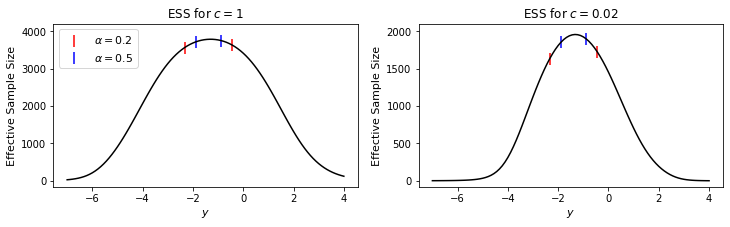

In [136]:
f = plt.figure(figsize = (12,3))
plt.subplot(1,2,1)
plt.plot(y_plot,ESS[i]*ESS_ratio,color = 'k')
colors = ['red','blue']
for a in range(n_alph):
    plt.scatter(y_plot[ind_band[a]],ESS[i,ind_band[a]]*ESS_ratio, color = colors[a],marker = '|',s = 150,\
            label = r'$\alpha = {}$'.format(alpha_range[a]))
plt.ylabel('Effective Sample Size',fontsize = 11)
plt.xlabel('$y$',fontsize = 11)
plt.legend(loc= 2,fontsize = 11)
plt.title(r'ESS for $c = 1$')
plt.ylim((-160.64, 4200))
plt.subplot(1,2,2)
plt.plot(y_plot,ESS_misspec[i]*ESS_ratio_misspec,color = 'k')
colors = ['red','blue']
for a in range(n_alph):
    plt.scatter(y_plot[ind_band_misspec[a]],ESS_misspec[i,ind_band_misspec[a]]*ESS_ratio_misspec, color = colors[a],marker = '|',s = 150,\
            label = r'$\alpha = {}$'.format(alpha_range[a]))
plt.ylabel('Effective Sample Size',fontsize = 11)
plt.xlabel('$y$',fontsize = 11)
plt.title(r'ESS for $c = 0.02$')
plt.ylim(-80,2100)
#f.savefig('plots/ESS_var_misspec.pdf', bbox_inches='tight')

# Compute LOO weights

In [137]:
import jax.numpy as jnp
from jax import jit
from functools import partial 
import numpy as np
import scipy as sp
from jax.scipy.stats import norm
from jax.scipy.special import logsumexp
from jax.ops import index_update

#Old version that uses naive IS average
# @jit #compute rank (unnormalized by n+1) 
# def compute_rank_IS_loo(logp_samp_n,logwjk):
#     n= jnp.shape(logp_samp_n)[1] #logp_samp_n is B x n
#     n_plot = jnp.shape(logwjk)[0]
#     rank_cp = jnp.zeros(n_plot)
    
#     #compute importance sampling weights and normalizing
#     logwjk_n = logwjk.reshape(n_plot,-1,1) - logp_samp_n.reshape(1,-1,n)
#     wjk_n = jnp.exp(logwjk_n)
#     print(np.shape(wjk_n))
#     Zjk_n = jnp.sum(wjk_n,axis = 1).reshape(n_plot,-1,n)
#     print(np.shape(Zjk_n))
    
#     #compute predictives for y_i,x_i and y_new,x_n+1
#     p_cp = jnp.sum(wjk_n/Zjk_n * jnp.exp(logp_samp_n).reshape(1,-1,n),axis = 1)    
    
#     wjk = jnp.exp(logwjk)
#     p_new = jnp.mean(wjk,axis = 1).reshape(-1,1)

#     #compute nonconformity score and sort
#     pred_tot = jnp.concatenate((p_cp,p_new),axis = 1)
#     rank_cp = np.sum(pred_tot <= pred_tot[:,-1].reshape(-1,1),axis = 1)
#     return rank_cp

#New version that cancels terms
@jit #compute rank (unnormalized by n+1)
def compute_rank_IS_loo(logp_samp_n,logwjk):
    n= jnp.shape(logp_samp_n)[1] #logp_samp_n is B x n
    n_plot = jnp.shape(logwjk)[0]
    rank_cp = jnp.zeros(n_plot)
    
    #compute importance sampling weights and normalizing
    logwjk_n = logwjk.reshape(n_plot,-1,1) - logp_samp_n.reshape(1,-1,n)
    print(np.shape(logwjk_n))
    wjk_n = jnp.exp(logwjk_n)
    Zjk_n = jnp.sum(wjk_n,axis = 1)
    
    #compute predictives for y_i,x_i and y_new,x_n+1
    wjk = jnp.exp(logwjk)
    wjk_sum = np.sum(wjk,axis = 1)
    p_cp = wjk_sum.reshape(-1,1)/Zjk_n
    
    T = np.shape(logwjk)[1]
    p_new = wjk_sum.reshape(-1,1)/T

    #compute nonconformity score and sort
    pred_tot = jnp.concatenate((p_cp,p_new),axis = 1)
    rank_cp = np.sum(pred_tot <= pred_tot[:,-1].reshape(-1,1),axis = 1)
    return rank_cp

#compute region of grid which is in confidence set
@jit
def compute_cb_loo_region_IS(alpha,logp_samp_n,logwjk): #assumes they are connected
    n= jnp.shape(logp_samp_n)[1]#logp_samp_n is B x n
    rank_cp = compute_rank_IS_loo(logp_samp_n,logwjk)
    region_true =rank_cp> alpha*(n+1)
    return region_true
## ##


@jit #compute ESS/var
def diagnose_is_loo_weights(logp_samp_n,logwjk):
    n= jnp.shape(logp_samp_n)[1] #logp_samp_n is B x n
    n_plot = jnp.shape(logwjk)[0]
    rank_cp = jnp.zeros(n_plot)
    
    #compute importance sampling weights and normalizing
    logwjk = logwjk.reshape(n_plot,-1, 1) 
    #divide by likelihood

    logwjk = logwjk - logp_samp_n.reshape(1,-1,n)
    logZjk = logsumexp(logwjk,axis = 1)
    
    #compute predictives for y_i,x_i and y_new,x_n+1
    logp_new = logsumexp(2*logwjk,axis = 1)-logZjk 

    #compute ESS
    wjk = jnp.exp(logwjk - logZjk.reshape(-1,1,n))
    ESS = 1/jnp.sum(wjk**2,axis = 1)

    #compute variance for p_new
    var = np.sum(wjk**2*(wjk - jnp.exp(logp_new).reshape(-1,1,n))**2,axis = 1)
    return ESS, var

In [138]:
#well spec
i = 1
alpha_range= np.array([0.2,0.5])
n_alph = np.shape(alpha_range)[0]
region_loo_cp = np.zeros((n_alph,np.shape(y_plot)[0]))
ind_loo_band = np.zeros((n_alph,2),dtype = 'int')
for a in range(n_alph):
    region_loo_cp[a] = compute_cb_loo_region_IS(alpha_range[a],logp_samp_n,logwjk[:,:,i])
    ind_loo_band[a] = np.where(np.diff(region_loo_cp[a])!=0)[0]

ESS_loo = np.zeros((n_test,np.shape(y_plot)[0],np.shape(logp_samp_n[0])[0]))
Var_loo = np.zeros((n_test,np.shape(y_plot)[0],np.shape(logp_samp_n[0])[0]))

#Compute ESS from IS weightss
ESS_loo[i], Var_loo[i] = diagnose_is_loo_weights(logp_samp_n,logwjk[:,:,i])
ESS_loo_ratio = 3793/np.shape(beta_post)[0] 

(100, 8000, 309)


(-160.64, 4200.0)

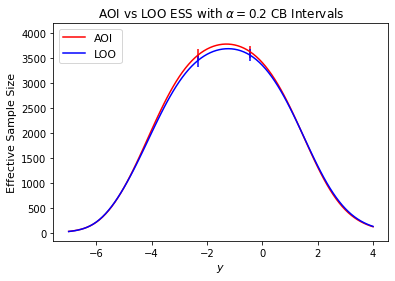

In [139]:
f = plt.figure(figsize = (6,4))


plt.plot(y_plot,ESS[i]*ESS_ratio,color = 'red',label = 'AOI')
colors = ['red','blue']
a = 0

plt.scatter(y_plot[ind_band[a]],ESS[i,ind_band[a]]*ESS_ratio, color = 'red',marker = '|',s = 150)
plt.ylabel('Effective Sample Size',fontsize = 11)
plt.xlabel('$y$',fontsize = 11)
plt.legend(loc= 2,fontsize = 11)
plt.title(r'AOI vs LOO ESS with $\alpha = 0.2$ CB Intervals')
plt.ylim((-160.64, 4200))

#plt.subplot(1,2,2)
plt.plot(y_plot,ESS_loo[i,:,1]*ESS_ratio,color = 'blue',label = 'LOO')
colors = ['red','blue']
plt.scatter(y_plot[ind_loo_band[a]],ESS_loo[i,ind_loo_band[a],1]*ESS_ratio, color = 'blue',marker = '|',s = 150)
plt.ylabel('Effective Sample Size',fontsize = 11)
plt.xlabel('$y$',fontsize = 11)
plt.legend(loc= 2,fontsize = 11)
plt.ylim((-160.64, 4200))
#f.savefig('plots/ESS_AOI_LOO.pdf', bbox_inches='tight')

### Timing

In [129]:
a = 0
i = 1
%timeit cb.compute_cb_region_IS(alpha_range[a],logp_samp_n,logwjk[:,:,i]).block_until_ready() #AOI
%timeit compute_cb_loo_region_IS(alpha_range[a],logp_samp_n,logwjk[:,:,i]).block_until_ready() #LOO

12 ms ± 281 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
314 ms ± 8.17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Plot $r(y)$

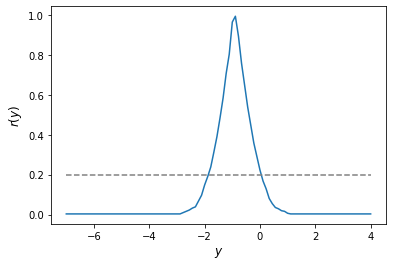

In [7]:
f = plt.figure()
i = 0
pi_y = cb.compute_rank_IS(logp_samp_n,logwjk[:,:,i])
plt.plot(y_plot,pi_y/(np.shape(logp_samp_n)[1]+1))
plt.xlabel(r'$y$',fontsize = 12)
plt.ylabel(r'$r(y)$', fontsize = 12)
plt.plot(y_plot,0.2*np.ones(np.shape(y_plot)[0]),color = 'grey', linestyle = 'dashed')
f.savefig("plots/ry.pdf", bbox_inches='tight')